<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Chemical Ground State calculation: Classical vs Quantum Computing**

In [ ]:
!pip install pyscf geometric periodictable qutip cirq openfermion openfermionpyscf -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize
import scipy.optimize
import itertools
import cirq
from openfermion import MolecularData, FermionOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

*Select Molecule*

In [ ]:
# Hydrogen (H₂)
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''
molecule = 'Hydrogen (H₂)'

In [ ]:
# Oxygen (O₂)
mol = gto.Mole()
mol.atom = '''
    O  0.00 0.00  0.00
    O  0.00 0.00  1.21
'''
molecule = 'Oxygen (O₂)'

In [ ]:
# Water (H₂O)
mol = gto.Mole()
mol.atom = '''
    O  0.000000  0.000000  0.000000
    H  0.000000  0.757000  0.586000
    H  0.000000 -0.757000  0.586000
'''
molecule = 'Water (H₂O)'

In [ ]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'sto-3g'  # sto-3g, cc-pvdz, 6-31G, for transition metals: 'def2-svp', 'def2-tzvp', 'lanl2dz'
mol.ecp = False       # Set to = mol.basis for Femoco
mol.symmetry = True
mol.spin = False
mol.charge = False
#mol.verbose = 4
mol.build()

In [ ]:
# Details about the molecule
def print_molecule_info(mol):
    print("="*50)
    print(f"Molecule Summary for {molecule}")
    print("="*50)
    print(f"Atoms: {mol.natm}")
    print(f"Electrons: {mol.nelectron}")
    print(f" Alpha electrons: {mol.nelec[0]}")
    print(f" Beta electrons: {mol.nelec[1]}")
    print(f"Basis: {mol.basis}")
    print(f"Basis functions: {mol.nao}")
    print(f"Charge: {mol.charge}")
    print(f"Spin (2S): {mol.spin}")
    print(f"Multiplicity (2S+1): {mol.spin + 1}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc():.6f} Hartree")
    # Point group symmetry
    print(f"Top group: {mol.topgroup}")
    print(f"Group name: {mol.groupname}")
    print("\nAtom Coordinates (Angstrom):")
    for ia in range(mol.natm):
        symb = mol.atom_symbol(ia)
        coord = mol.atom_coord(ia) * 0.52917721067
        print(f"  {symb:2s}  {coord[0]:10.6f}  {coord[1]:10.6f}  {coord[2]:10.6f}")
    print("="*50)
print_molecule_info(mol)

Molecule Summary for Hydrogen (H₂)
Atoms: 2
Electrons: 2
 Alpha electrons: 1
 Beta electrons: 1
Basis: sto-3g
Basis functions: 2
Charge: False
Spin (2S): False
Multiplicity (2S+1): 1
Nuclear repulsion energy: 0.715104 Hartree
Top group: Dooh
Group name: Dooh

Atom Coordinates (Angstrom):
  H     0.000000    0.000000    0.000000
  H     0.000000    0.000000    0.740000


**Quantum Ground State Calculation with UCCSD**

In [ ]:
# Choose Ansatz: 'UCCSD' or 'HEA' (Hardware Efficient, np.zeros + 0.01 initialization)
ANSATZ_TYPE = 'UCCSD'

In [ ]:
# Dynamic Bridge & Helpers

def get_hamiltonian_from_mole(mol):
    """Bridging function: PySCF Mol -> OpenFermion QubitOperator"""
    n_atoms = mol.natm
    basis = mol.basis
    multiplicity = mol.spin + 1
    charge = mol.charge

    print(f"-> Bridging Molecule: {n_atoms} atoms, Basis: {basis}, Multiplicity: {multiplicity}")

    symbols = [mol.atom_symbol(i) for i in range(n_atoms)]
    coords = mol.atom_coords(unit='Angstrom')
    geometry = [[symbols[i], list(coords[i])] for i in range(n_atoms)]

    molecule_data = MolecularData(geometry, basis, multiplicity, charge)
    molecule_data = run_pyscf(molecule_data, run_scf=True)

    mh = molecule_data.get_molecular_hamiltonian()
    fh = get_fermion_operator(mh)
    qubit_hamiltonian = jordan_wigner(fh)

    return qubit_hamiltonian, molecule_data.n_qubits, molecule_data.n_electrons

def get_uccsd_excitations(n_orbitals, n_electrons):
    """Generates indices for Single and Double excitations."""
    occupied_indices = range(n_electrons)
    virtual_indices = range(n_electrons, n_orbitals)

    single_excitations = []
    double_excitations = []

    for i in occupied_indices:
        for a in virtual_indices:
            single_excitations.append((i, a))

    for i, j in itertools.combinations(occupied_indices, 2):
        for a, b in itertools.combinations(virtual_indices, 2):
            double_excitations.append((i, j, a, b))

    return single_excitations, double_excitations

In [ ]:
# Ansatz Constructions

def create_hea_ansatz(qubits, n_electrons, params):
    """Hardware Efficient Ansatz"""
    circuit = cirq.Circuit()
    # Init HF
    for i in range(n_electrons): circuit.append(cirq.X(qubits[i]))

    n_q = len(qubits)
    param_idx = 0

    # Layer 1: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1
    # Layer 2: CNOT
    for i in range(n_q - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    # Layer 3: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1

    return circuit

def create_uccsd_ansatz(qubits, n_electrons, params, excitations):
    """
    Unitary Coupled Cluster Singles and Doubles (UCCSD) Ansatz.
    """
    circuit = cirq.Circuit()

    # 1. Initial State: Hartree-Fock
    for i in range(n_electrons):
        circuit.append(cirq.X(qubits[i]))

    # 2. Evolutions for Excitations
    param_idx = 0

    for exc in excitations:
        theta = params[param_idx]

        # Generator Construction
        if len(exc) == 2: # Single: i -> a
            i, a = exc
            generator = FermionOperator(((a, 1), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (a, 0)), 1.0)
        elif len(exc) == 4: # Double: i,j -> a,b
            i, j, a, b = exc
            generator = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)), 1.0)

        # Jordan-Wigner & Evolution
        qubit_generator = jordan_wigner(generator)
        for term, coeff in qubit_generator.terms.items():
            # Map to Cirq Pauli String
            pauli_map = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}
            qubit_pauli_map = {qubits[idx]: pauli_map[p_str] for idx, p_str in term}
            pauli_string = cirq.PauliString(qubit_pauli_map)

            # --- FIX FOR MODERN CIRQ ---
            # We want exp(theta * coeff * P).
            # Since generator is anti-hermitian, coeff is imaginary.
            # Cirq's P**t implements exp(i * pi * t * P).
            # We match the exponents: i * pi * t = theta * coeff
            # t = (theta * coeff.imag) / pi

            exponent = (theta * coeff.imag) / np.pi
            circuit.append(pauli_string ** exponent)

        param_idx += 1

    return circuit

In [ ]:
# Cost Function & VQE Execution

print("\n--- VQE Calculation ---")
print(f"Method Selected: {ANSATZ_TYPE}")

# A. Setup System
qubit_hamiltonian, n_qubits, n_electrons = get_hamiltonian_from_mole(mol)
n_orbitals = n_qubits
n_spatial = n_qubits // 2
print(f"System: {n_qubits} Qubits, {n_electrons} Electrons, {n_spatial} Spatial Orbitals")

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
simulator = cirq.Simulator()

# B. Determine Parameters and Excitations
excitations = []
num_params = 0

if ANSATZ_TYPE == 'UCCSD':
    singles, doubles = get_uccsd_excitations(n_qubits, n_electrons)
    excitations = singles + doubles
    num_params = len(excitations)
    print(f"UCCSD Excitations: {len(singles)} Singles, {len(doubles)} Doubles")

    # UCCSD works best starting near zero (Hartree-Fock)
    initial_params = np.zeros(num_params) + 0.01

elif ANSATZ_TYPE == 'HEA':
    # 2 layers of rotations * n_qubits
    num_params = 2 * n_qubits
    print(f"HEA Parameters: {num_params}")

    # HEA works best with Random initialization
    initial_params = np.random.uniform(0, 2*np.pi, num_params)

print(f"Total Parameters to optimize: {num_params}")

# C. Optimization Loop
def cost_function(params):
    if ANSATZ_TYPE == 'UCCSD':
        circuit = create_uccsd_ansatz(qubits, n_electrons, params, excitations)
    else:
        circuit = create_hea_ansatz(qubits, n_electrons, params)

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector
    sparse_H = get_sparse_operator(qubit_hamiltonian)
    return np.vdot(state_vector, sparse_H.dot(state_vector)).real

print("Optimizing...")
res = scipy.optimize.minimize(
    cost_function,
    initial_params,
    method='COBYLA',
    options={'maxiter': 3000, 'tol': 1e-6}
)

vqe_energy = res.fun
print(f"VQE Optimized Energy: {vqe_energy:.6f} Ha")

In [ ]:
# Classical Benchmarks
print("="*50)
print(f"Classical Benchmarks for Ground State Calculation for {molecule}")
print("="*50)

Classical Benchmarks for Ground State Calculation for Hydrogen (H₂)


In [ ]:
# old: Hartree-Fock
mf_hf = scf.RHF(mol)
mf_hf.verbose = 0
hf_energy = mf_hf.kernel()
print(f"Hartree-Fock Energy: {hf_energy:.6f} Ha")

In [ ]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mol.verbose = 3   # Select 4 or 5 for more detail
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -1.11675930739643


np.float64(-1.1167593073964255)

In [ ]:
# old: Ground State Energy with DFT (B3LYP)
mf_dft = dft.RKS(mol)
mf_dft.xc = 'B3LYP'
mf_dft.verbose = 0
dft_energy = mf_dft.kernel()
print(f"DFT (B3LYP) Energy:  {dft_energy:.6f} Ha")
print("-" * 30)

In [ ]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)  # Restricted Kohn Sham (often for closed shell systems)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()        # perform DFT calculation and return energy

converged SCF energy = -1.16541841052621


np.float64(-1.1654184105262066)

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
#mp2 = mp.MP2(mf) # MP2 single point energy calculation
#energy_mp2 = mp2.kernel()
#print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -1.11675930739643


np.float64(-1.1167593073964255)

In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
"""
Very accurate (often considered the "gold standard" for single-reference methods).
CCSD (singles and doubles), CCSD(T) (includes perturbative triples).
CCSD(T) is highly accurate but scales poorly with system size.
Almost exclusively formulated and implemented in second quantization due to its complexity.
"""
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()

ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
#ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
#print(f"HF-SCF energy: {hf_energy} Hartree")
#print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -1.11675930739643
E(CCSD) = -1.137283998610438  E_corr = -0.0205246912140128


In [ ]:
# Configuration Interaction

from pyscf import tdscf  # For CIS calculations (using TDHF)
from pyscf import ci     # For CISD calculations
from pyscf import fci    # For FCI calculations

"""
* CIS calculation: PySCF doesn't have a direct ci.CIS module. Instead, we use the Time-Dependent Hartree-Fock (TDHF) approach with the Tamm-Dancoff Approximation (TDA), which is equivalent to CIS for excited states.
* Wavefunction analysis: this is a simplified analysis of the CISD wavefunction by directly summing over the appropriate coefficients.

This script performs:
1. Hartree-Fock (HF) calculation as the reference
2. Configuration Interaction Singles (CIS)
3. Configuration Interaction Singles and Doubles (CISD)
4. Full Configuration Interaction (FCI) - note this is very computationally expensive

The code also analyzes the CISD wavefunction to show the contributions from the reference determinant, single excitations, and double excitations.

A few important notes:
- **CIS is primarily used for excited states, not ground state correlation energy (the first excited state energy is reported)**
- CISD includes single and double excitations and is commonly used for ground state calculations
- FCI is the exact solution within the given basis set but scales factorially with system size
- For larger molecules, you may want to use truncated CI methods or other approaches like CASCI (Complete Active Space CI)
"""

# Step 1: Perform a HF-SCF calculation to obtain the reference wavefunction
mf = scf.RHF(mol)
hf_energy = mf.kernel()
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")

# Step 2: Perform Configuration Interaction calculations

# CIS (Using TDHF which is equivalent to CIS for singlet excited states)
cis_calc = tdscf.TDA(mf)  # TDA approximation is equivalent to CIS
cis_e, cis_v = cis_calc.kernel()
cis_energy = cis_e[0] + hf_energy  # First excited state energy

# CISD
cisd_calc = ci.CISD(mf)
cisd_energy = cisd_calc.kernel()[0]  # Get the ground state energy

# FCI - Note: This can be very computationally expensive
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]

# Print the results
print(f"Molecule: {molecule}")
print(f"Basis Set: {mol.basis}")
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")
print(f"CIS excited state energy: {cis_energy:.8f} Hartree")
print(f"CIS excitation energy: {cis_e[0]:.8f} Hartree")
print(f"CISD correlation energy: {cisd_energy - hf_energy:.8f} Hartree")
print(f"CISD total energy: {cisd_energy:.8f} Hartree")
print(f"FCI correlation energy: {fci_energy - hf_energy:.8f} Hartree")
print(f"FCI total energy: {fci_energy:.8f} Hartree")

# Analyze the CISD wavefunction
cisd_coeff = cisd_calc.ci
print("\nCISD Wavefunction Analysis:")
print(f"Reference determinant weight: {cisd_coeff[0]**2:.6f}")

# Calculate contributions from singles and doubles
#from pyscf.ci import cisd_slow
nelec = mol.nelectron
nocc = nelec // 2
nvir = mf.mo_coeff.shape[1] - nocc

# Get singles and doubles contribution
singles_norm = 0
doubles_norm = 0

# Singles contribution
singles_norm = sum(abs(cisd_coeff[i])**2 for i in range(1, nocc*nvir+1))

# Doubles contribution
doubles_norm = sum(abs(cisd_coeff[i])**2 for i in range(nocc*nvir+1, len(cisd_coeff)))

print(f"Singles contribution: {singles_norm:.6f}")
print(f"Doubles contribution: {doubles_norm:.6f}")
print(f"Total normalization check: {cisd_coeff[0]**2 + singles_norm + doubles_norm:.6f}")

converged SCF energy = -1.11675930739643
HF-SCF energy: -1.11675931 Hartree
Excited State energies (eV)
[25.80746556]
E(RCISD) = -1.137283834488502  E_corr = -0.02052452709207653
Molecule: Hydrogen (H₂)
Basis Set: sto-3g
HF-SCF energy: -1.11675931 Hartree
CIS excited state energy: -0.16835243 Hartree
CIS excitation energy: 0.94840687 Hartree
CISD correlation energy: 1.09623478 Hartree
CISD total energy: -0.02052453 Hartree
FCI correlation energy: -0.02052453 Hartree
FCI total energy: -1.13728383 Hartree

CISD Wavefunction Analysis:
Reference determinant weight: 0.987334
Singles contribution: 0.000000
Doubles contribution: 0.012666
Total normalization check: 1.000000


In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

# Define the molecule with a rough guess for geometry (initial atomic positions)
# These positions don't need to be exact, as the optimization will refine them
mol.atom = mol.atom
mol.basis = mol.basis
mol.build()

# Take molecule including basis set defined from `mol.build()`
mf = dft.RKS(mol)     # Perform geometry optimization using DFT (Restricted Kohn-Sham)
mf.xc = 'b3lyp'       # Define the exchange-correlation functional
mol_eq = optimize(mf)

# Print optimized coordinates. This geometry corresponds to lowest energy configuration found during optimization process
#print("Optimized Geometry (in Angstroms):")
#print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-101d4735-8726-41a4-a679-686cc4a95877.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.740000    0.000000  0.000000  0.000000

WARN: Unable to to identify input symmetry using original axes.
Different symmetry axes will be used.


WARN: Mole.unit (angstrom) is changed to Bohr

converged SCF energy = -1.16541841052621
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0105382308
1 H     0.0000000000     0.0000000000     0.0105382308
----------------------------------------------
cycle 1: E = -1.16541841053  dE = -1.16542  norm(grad) = 0.0149033


Step    0 : Gradient = 1.054e-02/1.054e-02 (rms/max) Energy = -1.1654184105
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.91394e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.007124    0.000000  0.000000  0.377124
   H   0.000000   0.000000   0.732876    0.000000  0.000000  0.362876
converged SCF energy = -1.165529378209
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0024894002
1 H     0.0000000000     0.0000000000    -0.0024894002
----------------------------------------------
cycle 2: E = -1.16552937821  dE = -0.000110968  norm(grad) = 0.00352054


Step    1 : Displace = 7.124e-03/7.124e-03 (rms/max) Trust = 1.000e-01 (=) Grad = 2.489e-03/2.489e-03 (rms/max) E (change) = -1.1655293782 (-1.110e-04) Quality = 0.782
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 4.83852e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.005763    0.000000  0.000000  0.368639
   H   0.000000   0.000000   0.734237    0.000000  0.000000  0.371361
converged SCF energy = -1.16553552980966
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0000907194
1 H     0.0000000000     0.0000000000     0.0000907194
----------------------------------------------
cycle 3: E = -1.16553552981  dE = -6.1516e-06  norm(grad) = 0.000128297


Step    2 : Displace = 1.361e-03/1.361e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 9.072e-05/9.072e-05 (rms/max) E (change) = -1.1655355298 (-6.152e-06) Quality = 0.961
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 5.01484e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.005811    0.000000  0.000000  0.370048
   H   0.000000   0.000000   0.734189    0.000000  0.000000  0.369952
converged SCF energy = -1.16553553808743
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0000007443
1 H     0.0000000000     0.0000000000     0.0000007443
----------------------------------------------
cycle 4: E = -1.16553553809  dE = -8.27778e-09  norm(grad) = 1.0526e-06


Step    3 : Displace = 4.786e-05/4.786e-05 (rms/max) Trust = 2.000e-01 (+) Grad = 7.443e-07/7.443e-07 (rms/max) E (change) = -1.1655355381 (-8.278e-09) Quality = 1.009
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 5.01484e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 3.340 seconds


In [ ]:
# Comparison between Classical and Quantum Computation

print("\n--- Final Results Comparison ---")
print(f"Hartree-Fock: {hf_energy:.6f} Ha")
print(f"DFT (B3LYP):  {dft_energy:.6f} Ha")
print(f"VQE ({ANSATZ_TYPE}):   {vqe_energy:.6f} Ha")
print(f"Difference (VQE - HF): {vqe_energy - hf_energy:.6f} Ha")

Ground State Calculation for Hydrogen (H₂)

--- Classical Benchmarks ---
Hartree-Fock Energy: -1.116759 Ha
DFT (B3LYP) Energy:  -1.165418 Ha
------------------------------

--- Starting VQE Calculation ---
Method Selected: UCCSD
-> Bridging Molecule: 2 atoms, Basis: sto-3g, Multiplicity: 1
System: 4 Qubits, 2 Electrons, 2 Spatial Orbitals
UCCSD Excitations: 4 Singles, 1 Doubles
Total Parameters to optimize: 5
Optimizing... (This may take longer for UCCSD)
VQE Optimized Energy: -1.137284 Ha

--- Final Results Comparison ---
Hartree-Fock: -1.116759 Ha
DFT (B3LYP):  -1.165418 Ha
VQE (UCCSD):   -1.137284 Ha
Difference (VQE - HF): -0.020525 Ha


**Feasiblity (Qubit Count):**
* H₂ (STO-3G): 2 atoms × 1 orbital each × 2 spins = **4 Qubits** (Fast)
* H₂ (6-31G): 2 atoms × 2 orbitals each × 2 spins = **8 Qubits**  (Fast)
* H₂O (STO-3G): (2 H + 1 O) orbitals ... = **~14 Qubits** (Medium)
* O₂ (STO-3G): **~20 Qubits** (Slow)

**Circuit Structure**
* **Circuit Width (Qubit Count)**: In quantum chemistry, **1 Qubit = 1 Spin-Orbital**. Therefore, the number of spatial orbitals is exactly half the number of qubits. In the code, qubit count scales automatically based on the **basis set** (`sto-3g`, `6-31g`, etc.) and the **number of atoms**. The code handles qubit count automatically because `get_hamiltonian_from_mole` reads basis size directly.

* **Circuit Depth** is fixed in the code, defined by one block of entanglers (CNOTs) sandwiched by rotations. For very complex molecules (strongly correlated systems), this simple structure might be too shallow to capture the complex physics. One would need to repeat the `Ry -> CNOT -> Ry` layers multiple times (e.g., `depth=3` or `depth=5`) to get an accurate result.

**Baseline Methods**

* The baseline calculation is **Hartree-Fock**, a "Mean Field" approximation. It assumes electrons see each other as a static cloud of charge and ignores electron correlation (energy).

* The perfect solution is given by running a **Full CI (Correlation Interaction)** calculation. It diagonalizes the Hamiltonian directly (without a quantum circuit) to give the mathematically exact answer for this basis set. It considers also correlation energy.

**Ansatz**
* Choose **HEE** for Hardware Efficient Ansatz. It uses Rotation + CNOTs gates plus an optimizer from a given initialization. This can be either random. The code uses 'np.zeros + 0.01' initialization as a better starting point. It often suffers from "Barren Plateaus" (where the optimizer gets stuck) as the system gets larger.
* Choose **UCCSD** for Unitary Coupled Cluster. It is theoretically superior as it specifically targets the electron correlations (excitations). UCCSD is usually the better ansatz. It is physically derived from the Cluster Operator $e^{T - T^\dagger}$ and systematically excites electrons from occupied to unoccupied orbitals (Singles and Doubles excitations). It is chemically accurate and respects symmetries (number of electrons, spin, etc.). But it generates huge circuits (thousands of gates) that are very slow to simulate and impossible to run on current real hardware without error correction.


**Interpretation**

The quantum calculation is usually *lower* than Hartree-Fock. The difference (e.g. `-0.0205 Ha`) is exactly the **Correlation Energy** of a molecule.  The rotation and entanglement gates (CNOTs) are used to capture quantum mechanical behavior that Hartree-Fock ignores.



In [ ]:
# Kohn-Sham Hamiltonian (core Hamiltonian + exchange-correlation potential)
ks_hamiltonian = mf.get_hcore() + mf.get_veff()
#print("Kohn-Sham Hamiltonian matrix:\n", ks_hamiltonian)
print("Kohn-Sham Hamiltonian Matrix Shape:", ks_hamiltonian.shape)
print("Kohn-Sham Hamiltonian Matrix Size:", ks_hamiltonian.size)
print("Kohn-Sham Hamiltonian Matrix Dimension:", ks_hamiltonian.ndim)
print("Kohn-Sham Hamiltonian Matrix Trace:", np.trace(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Determinant:", np.linalg.det(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Rank:", np.linalg.matrix_rank(ks_hamiltonian))

Kohn-Sham Hamiltonian Matrix Shape: (10, 10)
Kohn-Sham Hamiltonian Matrix Size: 100
Kohn-Sham Hamiltonian Matrix Dimension: 2
Kohn-Sham Hamiltonian Matrix Trace: 6.08085800033746
Kohn-Sham Hamiltonian Matrix Determinant: -0.00043849081832920506
Kohn-Sham Hamiltonian Matrix Rank: 10


converged SCF energy = -181.193323036266


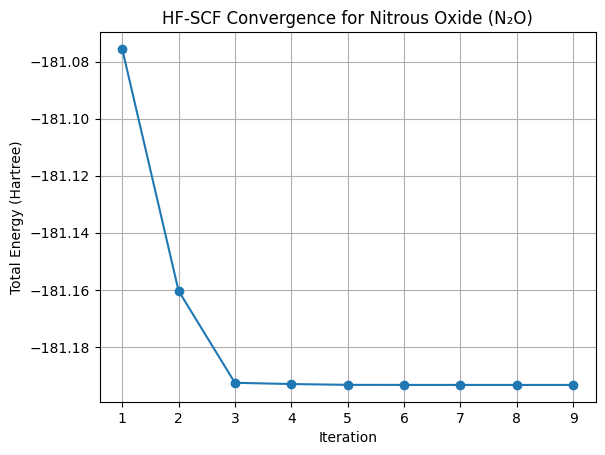

Ground state energy for Nitrous Oxide (N₂O): -181.193323036266 Hartree


In [ ]:
# Visualization of calculation process (Hartree-Fock)
mf = scf.RHF(mol)                         # Set method
conv_data = []                            # Store convergence data
def callback(envs):                       # Callback function to collect convergence information
    conv_data.append(envs['e_tot'])       # Captures energy values at each iteration to track process
mf.callback = callback                    # Set callback directly on the mf object
energy = mf.kernel()                      # Perform HF calculation
energies = conv_data                      # Extract energy values
iterations = range(1, len(energies) + 1)  # Extract iteration numbers
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title(f'HF-SCF Convergence for {molecule}')
plt.grid(True)
plt.show()
print(f"Ground state energy for {molecule}: {energy} Hartree")

In [ ]:
# HF-SCF Core Hamiltonian matrix
# represents one-electron part of molecular Hamiltonian
# = kinetic energy operator of electrons and electrostatic attraction operator between electrons and nuclei
# Core Hamiltonian does not include electron-electron interactions

# Get the core Hamiltonian (kinetic + nuclear attraction)
core_hamiltonian = mf.get_hcore()
#print("Core Hamiltonian matrix (Hcore):\n", core_hamiltonian)

# HF-SCF Fock Matrix

# Fock matrix approximates many-electron wavefunction of system (H₂O),
# i.e. approximates interactions between electrons in a system to find an optimal set of orbitals.
# It gives snapshot of molecule electronic structure, incl. energies of molecular orbitals and how they interact or mix

# Get the Fock matrix (core Hamiltonian + electron-electron interaction terms)
fock_matrix = mf.get_fock()
print("Fock Matrix (Hartree-Fock Hamiltonian):\n", fock_matrix)

print("Fock Matrix Shape:", fock_matrix.shape)
print("Fock Matrix Size:", fock_matrix.size)
print("Fock Matrix Dimension:", fock_matrix.ndim)
print("Fock Matrix Trace:", np.trace(fock_matrix))
print("Fock Matrix Determinant:", np.linalg.det(fock_matrix))
print("Fock Matrix Rank:", np.linalg.matrix_rank(fock_matrix))

Fock Matrix Shape: (10, 10)
Fock Matrix Size: 100
Fock Matrix Dimension: 2
Fock Matrix Trace: 7.237192699539285
Fock Matrix Determinant: -0.00786278789568637
Fock Matrix Rank: 10


In [ ]:
# HF-SCF Molecular Orbital Coefficients for All Orbitals (occupied and unoccupied)

# Retrieve Hartree-Fock orbitals (related to the Slater determinant) - occupied and unoccupied
# Occupied orbitals: contain electrons in Hartree-Fock ground state
# Virtual orbitals: unoccupied in ground state but can be important for excited state or post-Hartree-Fock methods like MP2 or CISD (electronic correlation effects)

# Get the molecular orbitals (which form the Slater determinant)
mo_coeff = mf.mo_coeff  # Coefficients of the molecular orbitals in the atomic basis
mo_energy = mf.mo_energy  # Orbital energies

print("Molecular Orbital Coefficients (MO coefficients):\n", mo_coeff)
print("Molecular Orbital Energies:\n", mo_energy)

In [ ]:
# HF-SCF Molecular Orbital Coefficients for only occupied orbitals

# Extract and display the occupied molecular orbitals - used to construct Slater determinant - Only occupied orbitals
# The mo_occ variable stores the occupation numbers, which are usually 2 for occupied orbitals
# in a closed-shell Hartree-Fock calculation (since there are two electrons per orbital in a closed-shell system).
# By identifying which orbitals are occupied using np.where(mo_occ > 0),
# the code extracts the coefficients corresponding to those occupied orbitals and prints them.

mo_coeff = mf.mo_coeff # Get molecular orbital coefficients
mo_occ = mf.mo_occ # Get occupation numbers (from orbitals)
occupied_indices = np.where(mo_occ > 0)[0] # Identify indices of occupied orbitals
occupied_mo_coeff = mo_coeff[:, occupied_indices] # Coefficients of occupied molecular orbitals
print("Occupied Molecular Orbital Coefficients:")
print(occupied_mo_coeff)

In [ ]:
# Calculate excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -1.12870009355644
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]

** Singlet excitation energies and oscillator strengths **
Excited State   1:  A1u     14.07567 eV     88.08 nm  f=0.6152
Excited State   2:  A1g     21.45479 eV     57.79 nm  f=0.0000
Excited State   3:  A1u     32.30709 eV     38.38 nm  f=0.2024
